In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../ to the sys path to access the coarsegraining package
sys.path.append(pwd + '/../src/')

In [3]:
import time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential
from coarsegrainer.GNN import GCN_CG, ResGCN_CG, GNNRes, GNN, GNNReparam
from coarsegrainer.plotting import plot_line_3D, plot_graph

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

# Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

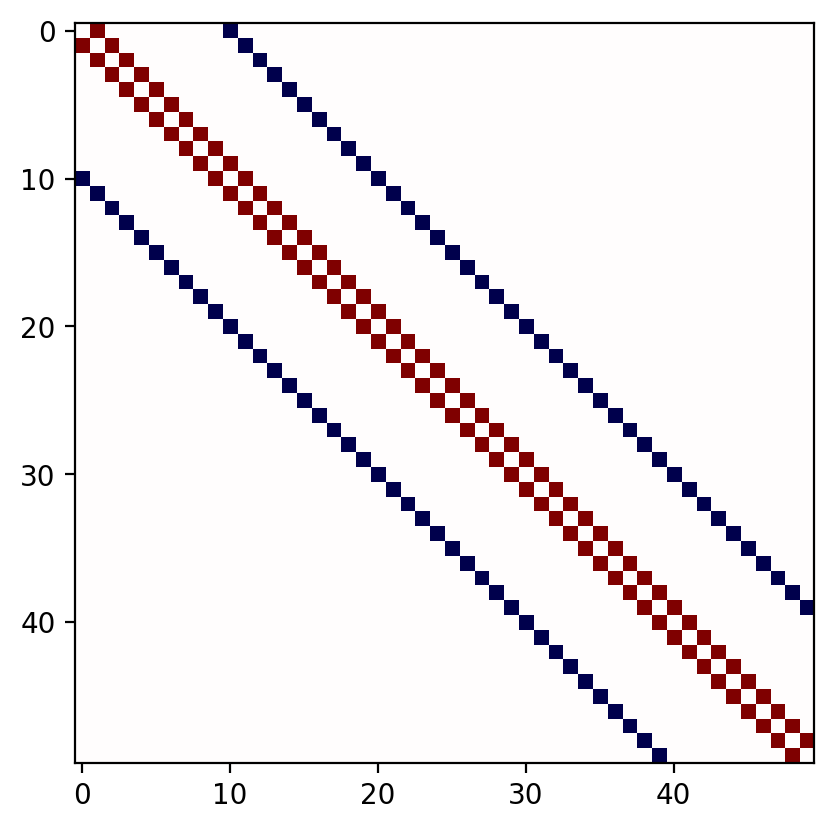

In [5]:
num_nodes, dims = 1000, 3

n,d = num_nodes, dims
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [6]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_bond_lj = Energy(A_list=[A, .1*vdw], energy_func_list=[quadratic_potential, LJ_potential],
                        log_name='Energy_Bond_LJ', **energy_params)

In [7]:
energy_bond_lj(x).item()

136.96212768554688

## Extract CG modes using multiple samples

In [8]:
# energy_bond_lj.num_neg_pairs = n**2//2
# energy_bond_lj.get_indices()
energy_bond_lj.indices_neg[0].shape

torch.Size([6907])

In [9]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# x_samples = init_sigma*8*torch.randn(4*n, n, d, device =device)
# even very few samples yield good quality cg_modes in this case
# x_samples = 5*init_sigma*torch.randn(4, n, d, device =device)
k = 10
# produce k samples with different std for x
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(3e-0, 8e-0, k)[:, None, None].to(device)

cg_bond_lj = cg.CG.CoarseGrainer(energy_bond_lj, num_cg_modes=n)
cg_bond_lj.get_cg_modes(x_samples)

cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.45 seconds
spectrum of the Laplacian computed in 0.04 seconds


0.5127058029174805

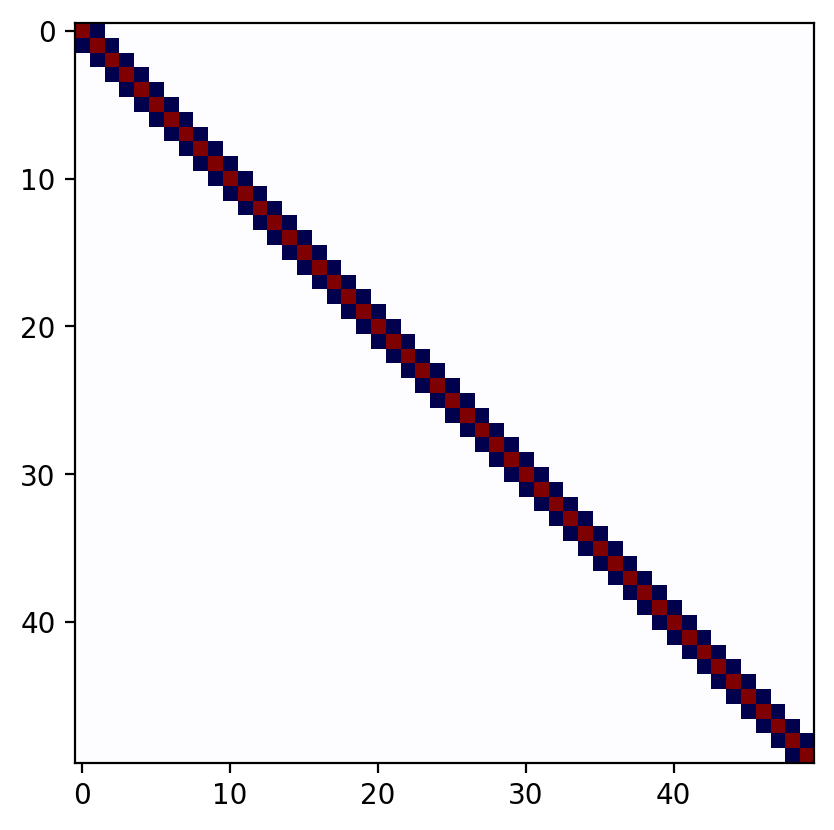

In [10]:
plt.imshow(np.arcsinh(1e4*V(cg_bond_lj.L))[:50,:50], cmap='seismic', vmin=-1, vmax=1)


/tmp/ipykernel_1730561/3819357837.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(c / np.sign(c[[0]]), cmap='seismic', vmin=-b, vmax=b)
/tmp/ipykernel_1730561/3819357837.py:7: RuntimeWarning: invalid value encountered in divide
  plt.imshow(c / np.sign(c[[0]]), cmap='seismic', vmin=-b, vmax=b)


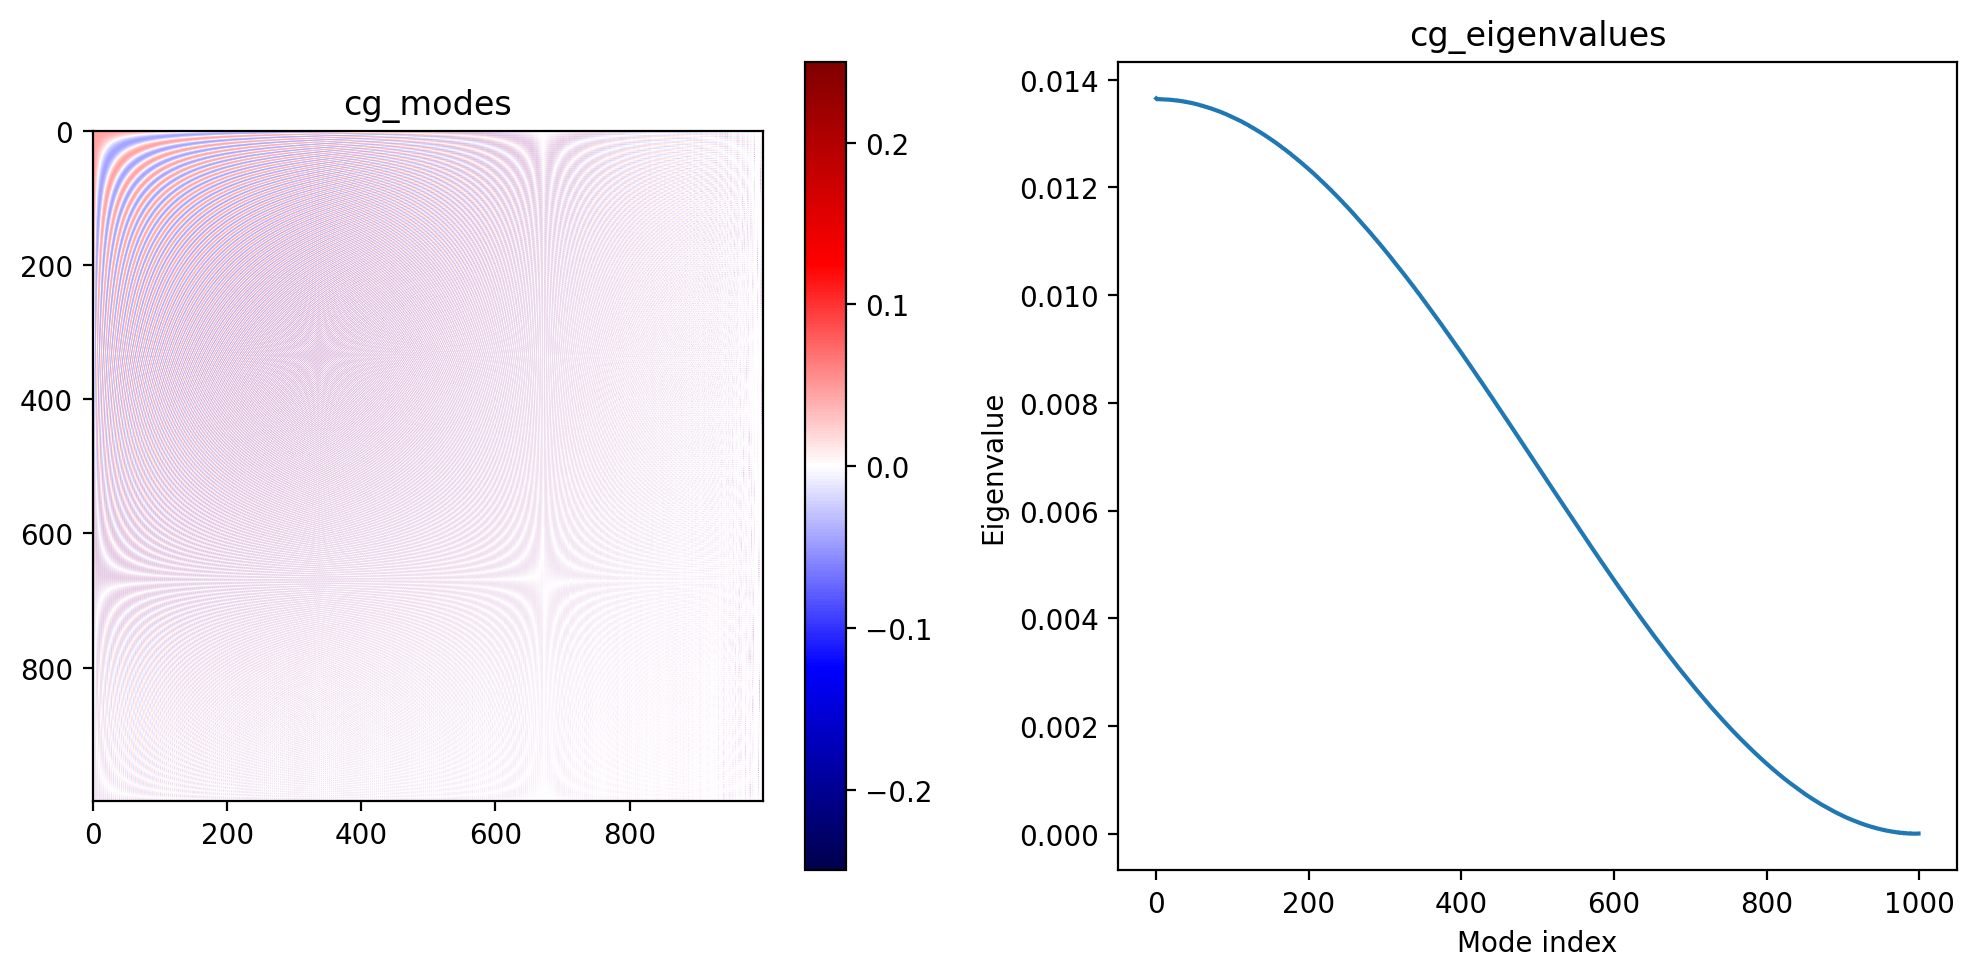

In [11]:
c = V(cg_bond_lj.cg_modes)
plt.figure(figsize=(10, 5))

# Plot cg_modes
plt.subplot(1, 2, 1)
b = .25
plt.imshow(c / np.sign(c[[0]]), cmap='seismic', vmin=-b, vmax=b)
plt.title('cg_modes')
plt.colorbar()

# Plot cg_eigenvalues
plt.subplot(1, 2, 2)
plt.plot(V(cg_bond_lj.cg_eigenvalues))
plt.title('cg_eigenvalues')
plt.xlabel('Mode index')
plt.ylabel('Eigenvalue')

plt.tight_layout()
plt.show()

# c = V(cg_bond_lj.cg_modes)
# plt.imshow(c/np.sign(c[[0]]), cmap='seismic', vmin=-1, vmax=1) 

## Training
We run a set of experiments with different hyperparameters.  

In [14]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment_n{}_d{}_loop{}_a{}_'.format(n,d,loop,a)) 


In [15]:
# Base value for hyperparameters
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 2e-2

## Bonds + LJ
quadratic potential along bonds and LJ for weak interactions. 

In [16]:
# define the initial position
initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) / 2

init_x_std = x.std().item()

# Example runs

In [17]:
test_logger = ExperimentLogger(save_prefix='../results/test')

In [32]:
# example of using the EnergyMinimizerPytorch class
# instantiate the EnergyMinimizerPytorch class
energy_minimizer = EnergyMinimizerPytorch(energy_bond_lj, initial_pos, optimizer_type='Adam', lr=2*LR, clamp_grads=1., log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='Bond_LJ', patience=PATIENCE, min_delta=MIN_DELTA*1e-1)

Using Adam optimizer
Log name: Bond_LJ
Logging to: ../results/logs/Bond_LJ_n1000_d3


In [33]:
# exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item(), num_nodes=num_nodes)
test_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item(), num_nodes=num_nodes)

Running experiment Bond_LJ_n1000_d3
250 -0.0165, 4.82
500 -0.0215, 9.45
750 -0.0221, 14.18
1000 -0.0226, 18.82
Early stopping at step 3560
1179 -0.0227, 22.12


In [34]:
test_logger.df

energy_function               model_name    energy       time    lr  \
0  Energy_Bond_LJ         Bond_LJ_n1000_d3 -0.022494  19.219028  0.02   
1  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.023393  20.130974  0.04   
2  Energy_Bond_LJ         Bond_LJ_n1000_d3 -0.022720  22.115201  0.04   

   clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0          1.0        20  1.000000e-07  2.528454       1000    NaN   
1          0.2        20  1.000000e-06  2.528454       1000   0.07   
2          1.0        20  1.000000e-07  2.528454       1000    NaN   

   cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  
0          NaN           NaN       NaN        NaN        NaN  
1         20.0       0.00001     660.0  13.800858  -0.021995  
2          NaN           NaN       NaN        NaN        NaN

Text(0.5, 1.0, 'Energy vs time (min E: -0.0227, t=22.12 s)')

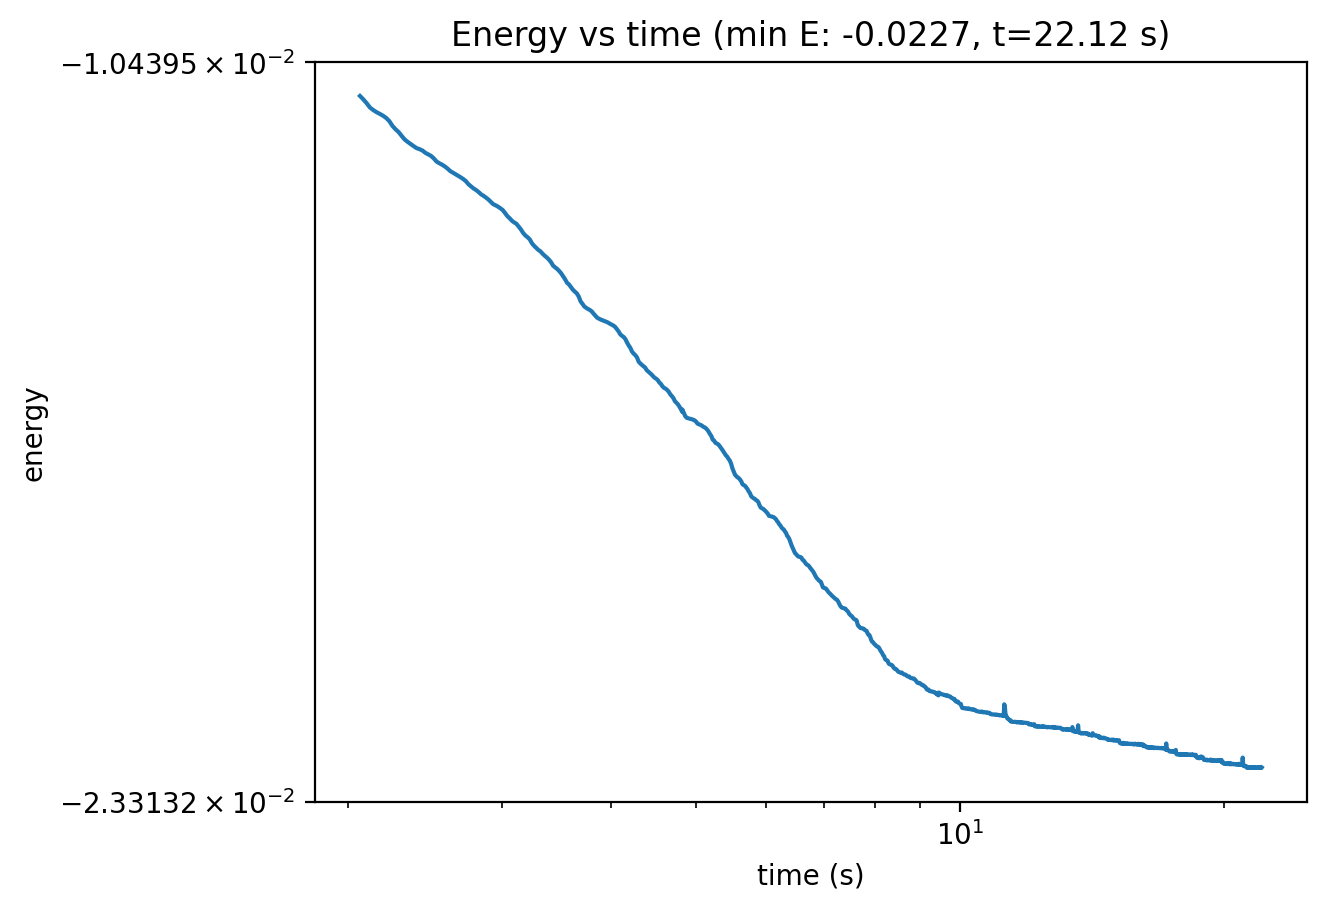

In [35]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [36]:
r = 5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
LR

0.02

In [77]:
num_cg_modes = n//3
# num_cg_modes = n//4

# initial_pos = x = init_sigma*torch.randn(n, d).to(device) /2
# instantiate the CGMinimizerPytorch class
cg_minimizer = CGMinimizerPytorch(energy_bond_lj, initial_pos, cg_bond_lj.cg_modes[:,:num_cg_modes], 
            optimizer_type='Adam', lr=2*LR, 
            lr_cg= 1*LR,#7e-2,#5e-2,
            clamp_grads=.2, log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name=f'CG_Bond_LJ{num_cg_modes/n:.2f}', 
            patience=PATIENCE, min_delta=MIN_DELTA*1e-1,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*1e1)


# exp_logger.start_experiment(energy_bond_lj.log_name, n, f'CG({num_cg_modes/n:.2f})')

Using Adam optimizer
Log name: CG_Bond_LJ0.33
Logging to: ../results/logs/CG_Bond_LJ0.33_n1000_d3
Using Adam optimizer


In [78]:
cg_minimizer.energy_func(x).item(), cg_minimizer.energy_func(cg_minimizer.get_x()).item()

(28.122756958007812, 2.7606608867645264)

In [79]:
# remove the last experiment
# exp_logger.results = exp_logger.results[:-1]
# x.std().item(), cg_minimizer.get_x().std().item(), init_sigma

In [80]:
# exp_logger.run_experiment(cg_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item(), num_nodes=num_nodes)
test_logger.run_experiment_cg(cg_minimizer, cg_time, epochs=10, steps=5000, x0_std=initial_pos.std().item(), num_nodes=num_nodes)

Running experiment CG_Bond_LJ0.33_n1000_d3


250 -0.014, 4.99
500 -0.0208, 9.83
750 -0.0225, 14.65
Early stopping at step 1760
Starting fine-graining
Early stopping at step 3060
993 -0.0234, 19.20


In [81]:
test_logger.df

energy_function               model_name    energy       time    lr  \
0  Energy_Bond_LJ         Bond_LJ_n1000_d3 -0.022494  19.219028  0.02   
1  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.023393  20.130974  0.04   
2  Energy_Bond_LJ         Bond_LJ_n1000_d3 -0.022720  22.115201  0.04   
3  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.014651  14.392456  0.04   
4  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.014666  14.246824  0.04   
5  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.014929  13.080447  0.04   
6  Energy_Bond_LJ  CG_Bond_LJ0.25_n1000_d3 -0.014612  12.873523  0.04   
7  Energy_Bond_LJ  CG_Bond_LJ0.33_n1000_d3 -0.023267  13.609634  0.04   
8  Energy_Bond_LJ  CG_Bond_LJ0.33_n1000_d3 -0.023396  23.181776  0.04   
9  Energy_Bond_LJ  CG_Bond_LJ0.33_n1000_d3 -0.023376  19.713565  0.04   

   clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0          1.0        20  1.000000e-07  2.528454       1000    NaN   
1          0.2        20  1.000000e-06  2.528454       1000   0.07   
2          1.0        20  1.000000e-07  2.528454       1000    NaN   
3          0.2        20  1.000000e-07  2.528454       1000   0.04   
4          0.2        20  1.000000e-07  2.528454       1000   0.04   
5          0.2        20  1.000000e-07  2.528454       1000   0.04   
6          0.2        20  1.000000e-07  2.528454       1000   0.06   
7          0.2        20  1.000000e-07  2.528454       1000   0.06   
8          0.2        20  1.000000e-07  2.528454       1000   0.02   
9          0.2        20  1.000000e-07  2.528454       1000   0.02   

   cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  
0          NaN           NaN       NaN        NaN        NaN  
1         20.0      0.000010     660.0  13.800858  -0.021995  
2          NaN           NaN       NaN        NaN        NaN  
3         20.0      0.000010     602.0  12.289237  -0.013585  
4         20.0      0.000010     553.0  11.317684  -0.013574  
5         20.0      0.000001     520.0  10.725865  -0.014106  
6         20.0      0.000001     368.0   7.876864  -0.011369  
7         20.0      0.000001     266.0   5.792342  -0.018579  
8         20.0      0.000001    1060.0  21.664757  -0.023097  
9         20.0      0.000010     839.0  16.872578  -0.022750

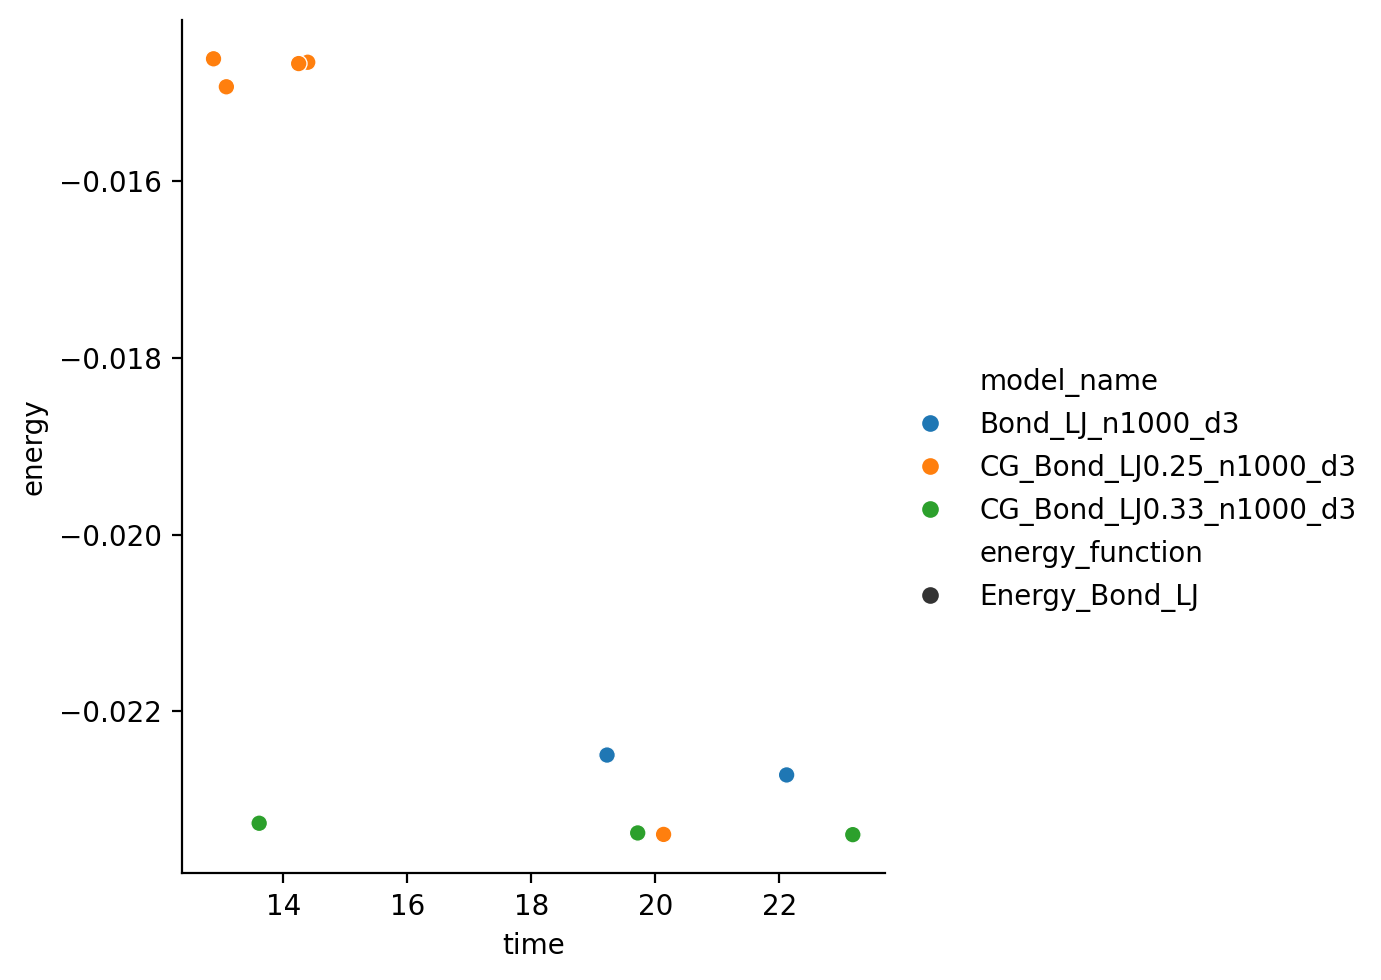

In [82]:
test_logger.plot_results(x='time', y='energy', hue='model_name', style='energy_function')
# plt.ylim(-.0247, -.023)

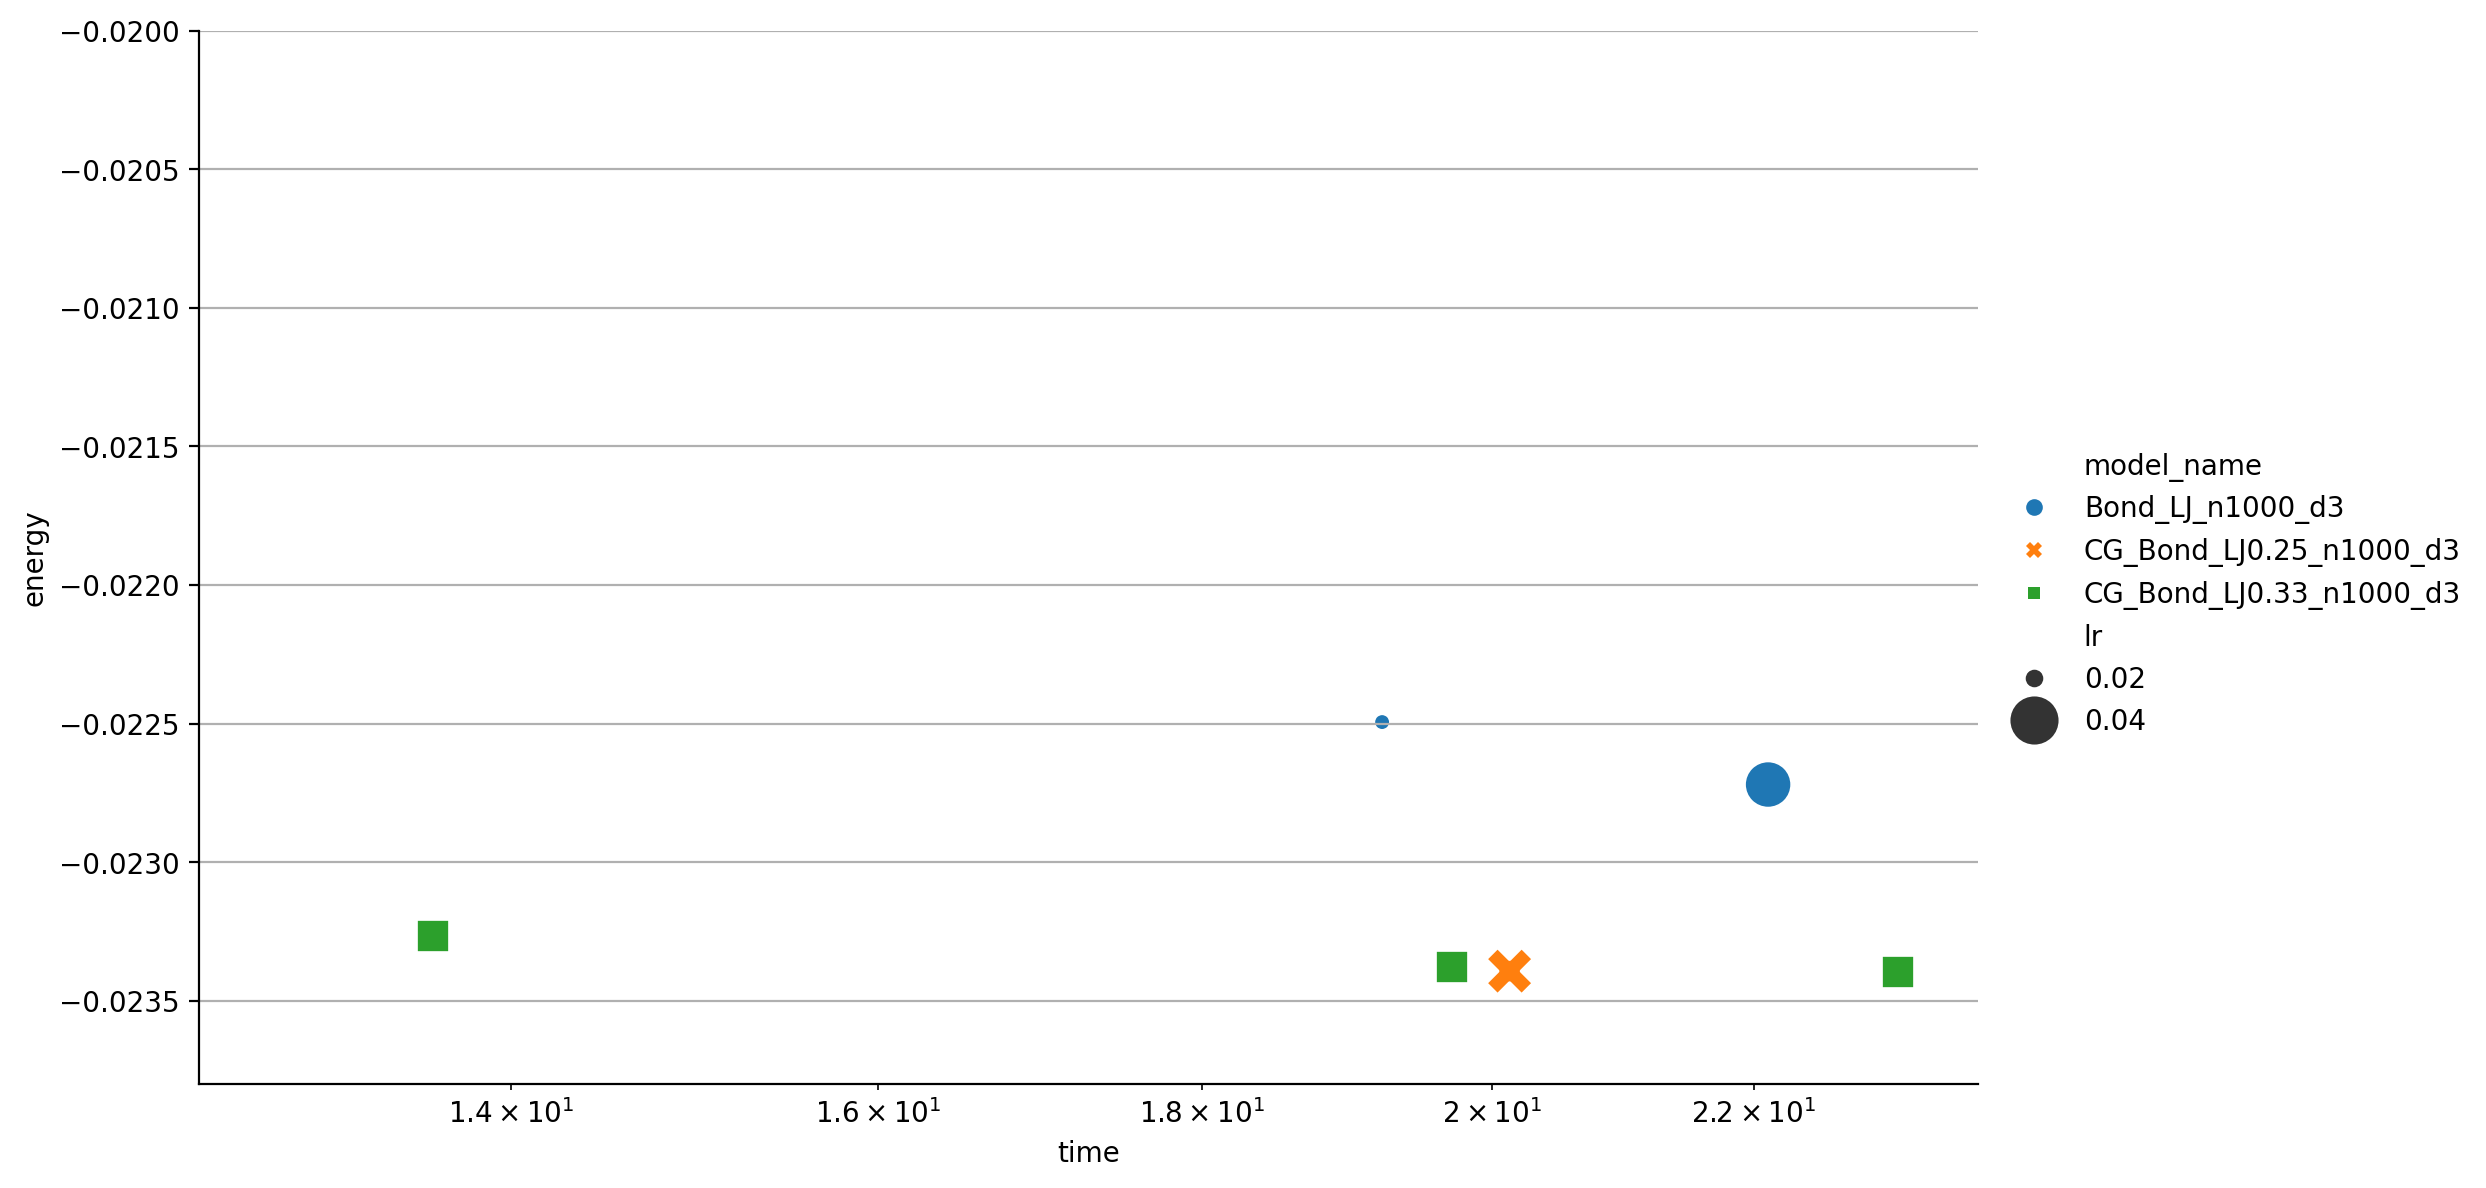

In [83]:
df = test_logger.df
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(40, 300))

plt.ylim(-.0238, -.02)
# plt.xlim(7,30)
plt.xscale('log')
plt.grid()

Text(0.5, 1.0, 'Energy vs time (min E: -0.0234, t=19.20 s)')

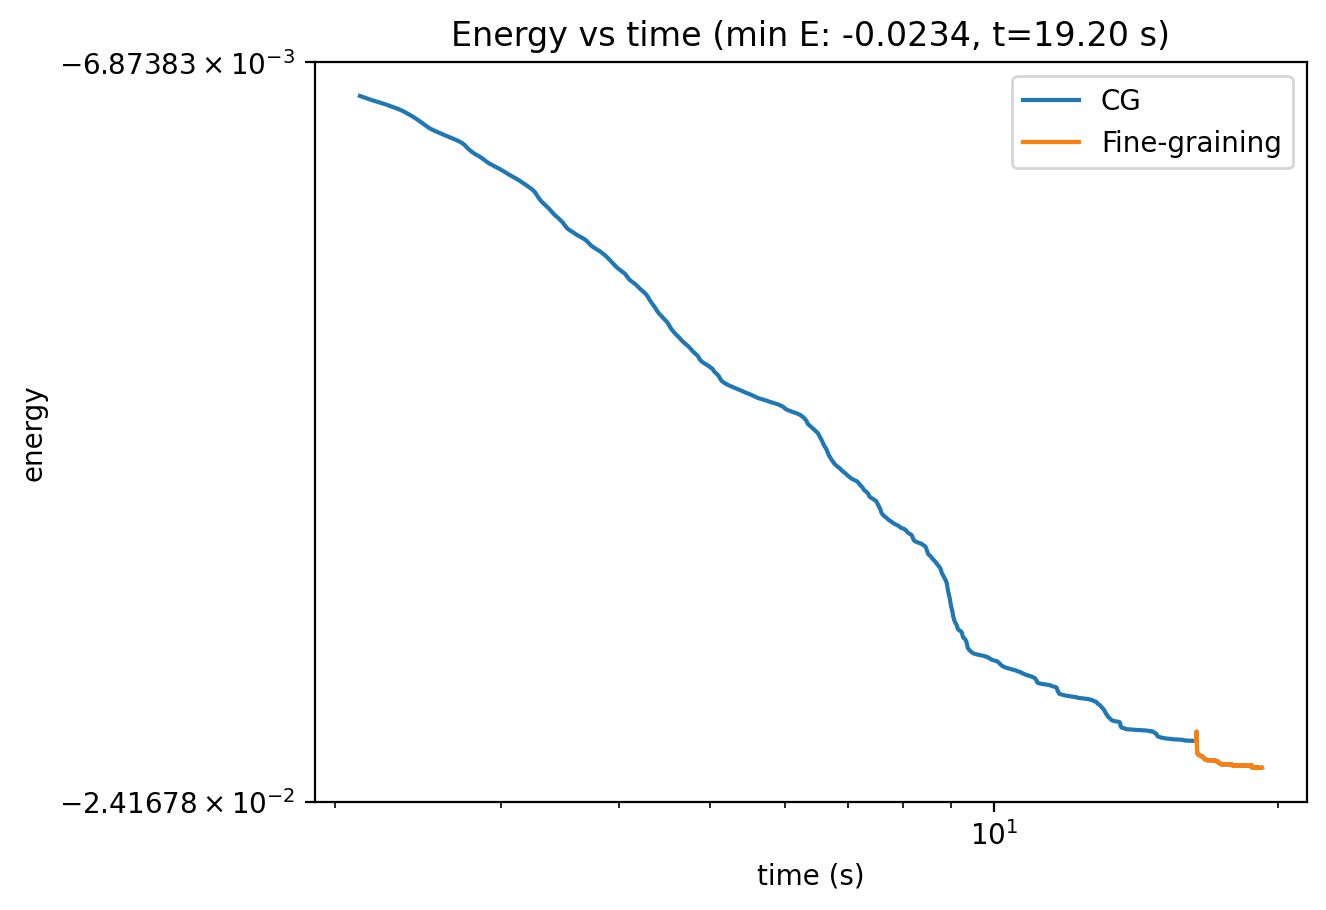

In [87]:
cg_minimizer.plot_history(start=100)
cg_minimizer.plot_history(start=cg_minimizer.cg_steps)
plt.legend(['CG', 'Fine-graining'])
h = cg_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [85]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### more strict CG
use fewer CG modes and looser early stopping

In [154]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## GNN

In [15]:
# example of using the GCN_CG class
h = 10

num_cg_modes = n//4
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, h).to(device)

# instantiate the GCN_CG class
gcn = GCN_CG(h, d, cg_bond_lj, num_cg=num_cg_modes, bias=True).to(device)

# instantiate the ResGCN_CG class
resgcn = ResGCN_CG(h, d, cg_bond_lj, num_cg=num_cg_modes, bias=True).to(device)

# instantiate the GNN class
gnn = GNN([h, h//2, d], cg_bond_lj, num_cg=num_cg_modes, bias=True).to(device)

# parameters count for the GCN_CG class
[(torch.norm(p).item(),p.shape) for p in gcn.parameters()]

[(1.9676259756088257, torch.Size([10, 3])),
 (0.0, torch.Size([3])),
 (4.555346965789795, torch.Size([10, 3]))]

In [53]:
gnn_reparam = GNNReparam([h, h//2, d], cg_bond_lj, num_cg=num_cg_modes, latent_sigma=init_sigma, bias=True).to(device)

In [54]:
# get the cg_modes from gnn_reparam
gnn_reparam.gnn.layers[0].cg_modes_scaled.shape

torch.Size([400, 100])

In [55]:
gnn

GNN(
  (layers): ModuleList(
    (0): GCN_CG()
    (1): Linear(in_features=5, out_features=3, bias=True)
  )
  (act): ReLU()
)

In [115]:
# example of using the GNNMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=10
num_cg_modes = n//5

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//2, d], cg_bond_lj, num_cg=num_cg_modes, latent_sigma=1/np.sqrt(h), bias=True, activation=torch.nn.Tanh()).to(device)
print(f"std before rescaling {gnn_reparam().std().item():.3g}")

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

init_gnn_std = gnn_reparam().std()
# rescale the weights of the last layer by the ratio of the stds
# gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.

gnn_reparam.gnn.layers[-1].weight.data *= x.std().item()/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
gnn_minimizer = GNNMinimizerPytorch(energy_bond_lj, initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=2*LR, lr_gnn=2e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e1, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e1)


Initial std of x: 1.9
std before rescaling 0.391
std after rescaling 1.85
Using Adam optimizer
Log name: GNN_Bond_LJ0.20
Logging to: ../results/logs/GNN_Bond_LJ0.20_n400_d3
Using Adam optimizer


In [147]:

class GNNReparam(torch.nn.Module):
    def __init__(self, hidden_dims, cg, num_cg, latent_sigma='auto', 
                bias=True, activation=torch.nn.ReLU(), GNN_class=GNN):
        """This is a class to implement the graph neural network reparameterization.
        

        Args:
            hidden_dims (list): The list of hidden dimensions. 
                The first element is the input dimension and 
                the last element is the output dimension. 
                It should have at least two elements.
            cg (object): The object containing the cg_modes and cg_eigenvalues.
            num_cg (int): The number of cg_modes to use.
            initial_pos (torch.Tensor): The initial position of the particles.
            bias (bool, optional): Whether to include a bias term. 
                Defaults to True.
            activation (torch.nn.Module, optional): The activation function. 
                Defaults to torch.nn.ReLU().
        """
        super().__init__()
        self.hidden_dims = hidden_dims
        self.num_cg = num_cg
        self.gnn = GNN_class(hidden_dims, cg, num_cg, bias, activation)
        self.n = cg.cg_modes.shape[0]
        self.get_latent_embedding(latent_sigma)
        # self.rescale_output(output_init_sigma)
        
    def get_latent_embedding(self, latent_sigma):
        # get the latent embedding
        if latent_sigma == 'auto':
            latent_sigma = 1/np.sqrt(self.hidden_dims[0])
            # we use the std of the initial position to scale the initial position
            # self.latent_embedding = torch.nn.Parameter(self.gnn(self.initial_pos).std() * torch.randn(self.n, self.gnn.hidden_dims[0]))
        # we use the latent_sigma to scale the initial position
        self.latent_embedding = torch.nn.Parameter(latent_sigma * torch.randn(self.n, self.gnn.hidden_dims[0]))
        
        
    def rescale_output(self, output_init_sigma):
        # rescale the output to match the std of the initial position
        init_gnn_std = self().std() 
        # rescale the weights of the last layer by the ratio of the stds
        self.gnn.layers[-1].weight.data *= output_init_sigma/init_gnn_std
        
    def forward(self):
        # compute the reparameterized x
        # assume x is of shape (n, in_features)
        return self.gnn(self.latent_embedding)

In [148]:
x.std()

tensor(1.9017, device='cuda:0')

In [17]:
h=10
num_cg_modes = n//5

n = len(A)

init_x_std = x.std().item()
print(f"Initial std of x: {init_x_std:.3g}")

gnn_reparam = GNNReparam([h, h//2, d], cg_bond_lj, num_cg=num_cg_modes, 
                        bias=True, activation=torch.nn.Tanh()).to(device)
print(f"Init std of GNN output: {gnn_reparam().std().item():.3g}")
gnn_reparam.rescale_output(init_x_std)
print(f"std of GNN output after rescaling: {gnn_reparam().std().item():.3g}")



Initial std of x: 3.75
Init std of GNN output: 0.262
std of GNN output after rescaling: 3.5


In [135]:
gnn_reparam()

tensor([[ 0.3826,  0.1826, -0.0121],
        [ 0.3301, -0.1006, -0.3966],
        [ 0.2253,  0.4129, -0.4474],
        ...,
        [ 0.2376, -0.0806, -0.5936],
        [-0.2296,  1.1873, -0.1024],
        [ 0.3580,  0.4297, -0.4287]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
gnn_minimizer.energy_func(x), gnn_minimizer.energy_func(gnn_minimizer.get_x())

(tensor(680.2264, device='cuda:0'),
 tensor(43.4323, device='cuda:0', grad_fn=<AddBackward0>))

In [27]:
# exp_logger.run_experiment_gnn(gnn_minimizer,cg_mode_time=cg_time,epochs=10, steps=5000, x0_std=gnn_minimizer.get_x().std().item())
test_logger.run_experiment_gnn(gnn_minimizer,cg_mode_time=cg_time,epochs=10, steps=5000, x0_std=gnn_minimizer.get_x().std().item())

Running experiment GNN_Bond_LJ0.20_n400_d3


250 -0.0216, 6.01
500 -0.0241, 11.91
Early stopping at step 300
Early stopping at step 4520
743 -0.0245, 16.46


In [28]:
test_logger.df

energy_function               model_name    energy       time  num_cg_modes  \
0  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.022962  17.031980            80   
1  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.024336  16.141128            80   
2  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.024466  16.636397            80   

     lr  lr_cg  clamp_grads  patience  min_delta  cg_patience  cg_min_delta  \
0  0.04  0.002         0.01        20    0.00001           20       0.00001   
1  0.04  0.002         0.01        20    0.00001           20       0.00001   
2  0.04  0.002         0.01        20    0.00001           20       0.00001   

   cg_steps    cg_time  cg_energy hidden_dims    x0_std  
0       520  12.619572  -0.022410  [10, 5, 3]  3.240644  
1       514  12.490475  -0.023731  [10, 5, 3]  2.660782  
2       516  12.440299  -0.024125  [10, 5, 3]  2.909130

In [29]:
# exp_logger.results[-7]['model_name']
# exp_logger.results = exp_logger.results[:-2]
# exp_logger.to_dataframe()

Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=16.46 s)')

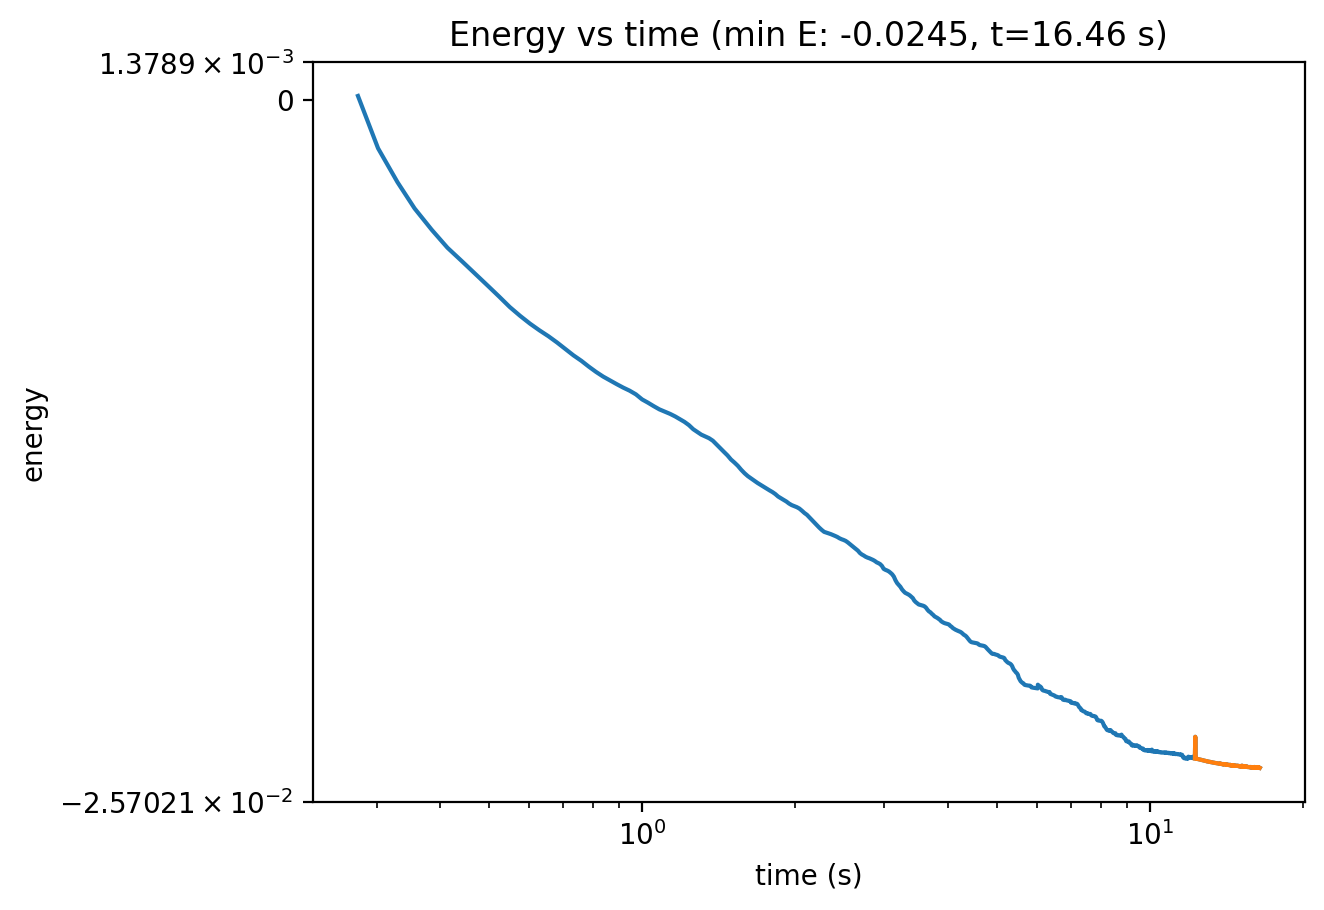

In [30]:
gnn_minimizer.plot_history(start=10)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [66]:
exp_logger.df[-10:]

energy_function                     model_name    energy       time    lr  \
0  Energy_Bond_LJ        Energy_Bond_LJ2_n400_d3 -0.024446  14.371836  0.03   
1  Energy_Bond_LJ  Energy_Bond_LJ_CG0.25_n400_d3 -0.024531   9.307590  0.04   
2  Energy_Bond_LJ        GNN_Bond_LJ0.25_n400_d3 -0.024449  15.204830  0.04   
3  Energy_Bond_LJ        GNN_Bond_LJ0.20_n400_d3 -0.024441  16.536901  0.04   

   clamp_grads  patience  min_delta    x0_std  lr_cg  cg_patience  \
0         1.00        20   0.000001  1.850011    NaN          NaN   
1         1.00        20   0.000001  1.850012  0.100         20.0   
2         0.01        20   0.000010  3.439259  0.004         20.0   
3         0.01        20   0.000010  3.202150  0.002         20.0   

   cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes hidden_dims  
0           NaN       NaN        NaN        NaN           NaN         NaN  
1       0.00002     206.0   4.392176  -0.023036           NaN         NaN  
2       0.00001     475.0  11.655489  -0.024160         100.0  [10, 5, 3]  
3       0.00001     516.0  12.541321  -0.023213          80.0  [10, 5, 3]

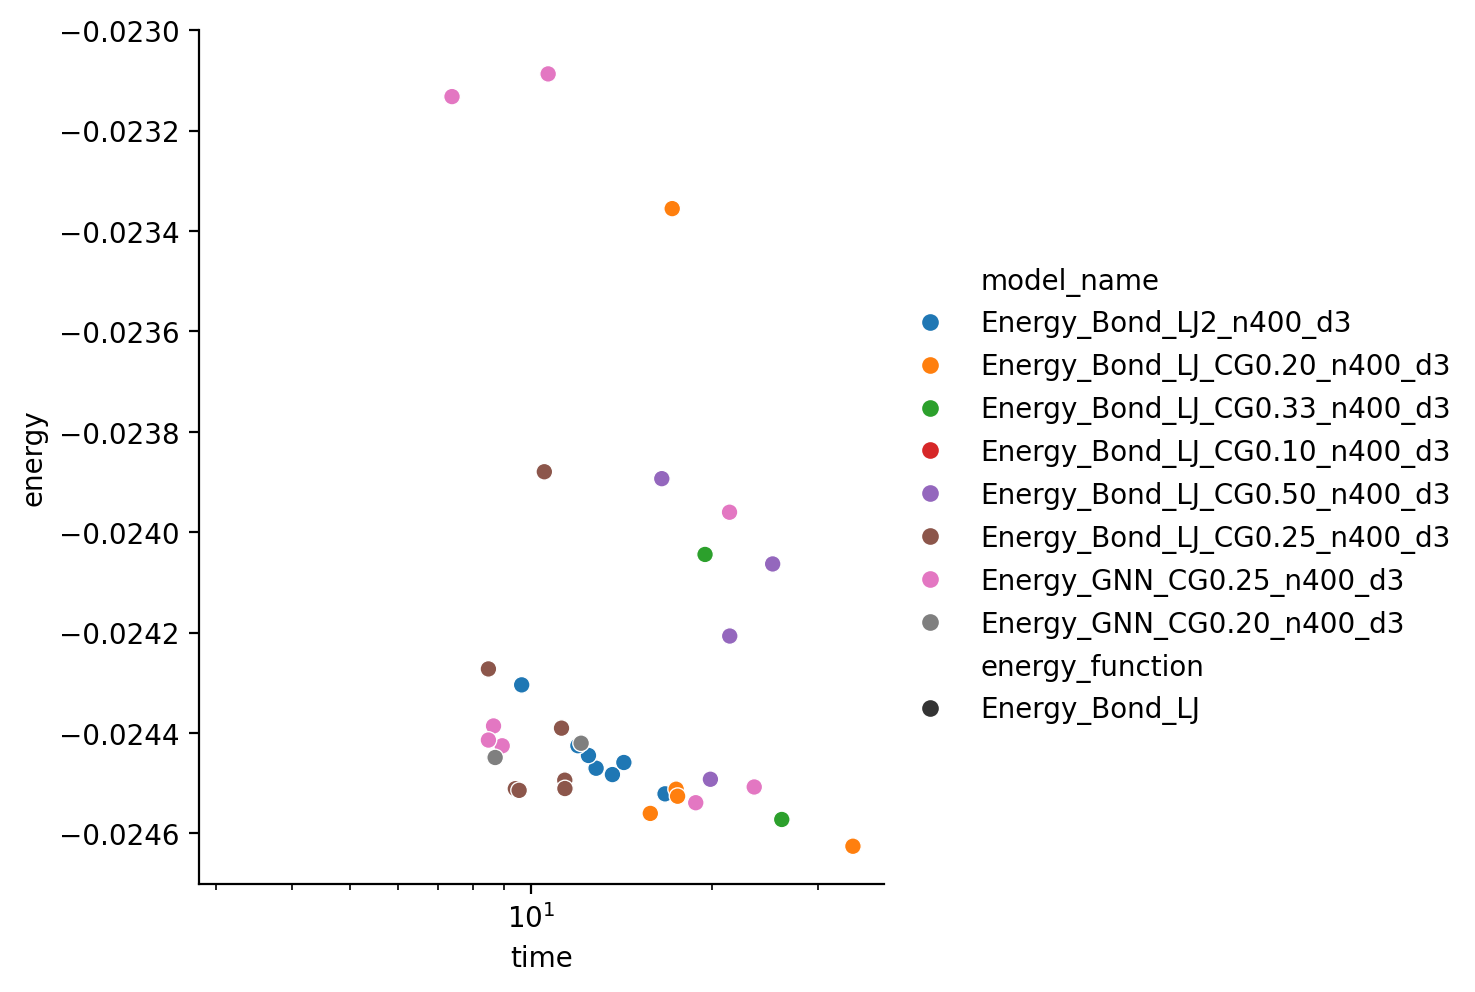

In [212]:
exp_logger.plot_results(x='time', y='energy', hue='model_name', style='energy_function')
plt.ylim(-.0247, -.023)
plt.xscale('log')

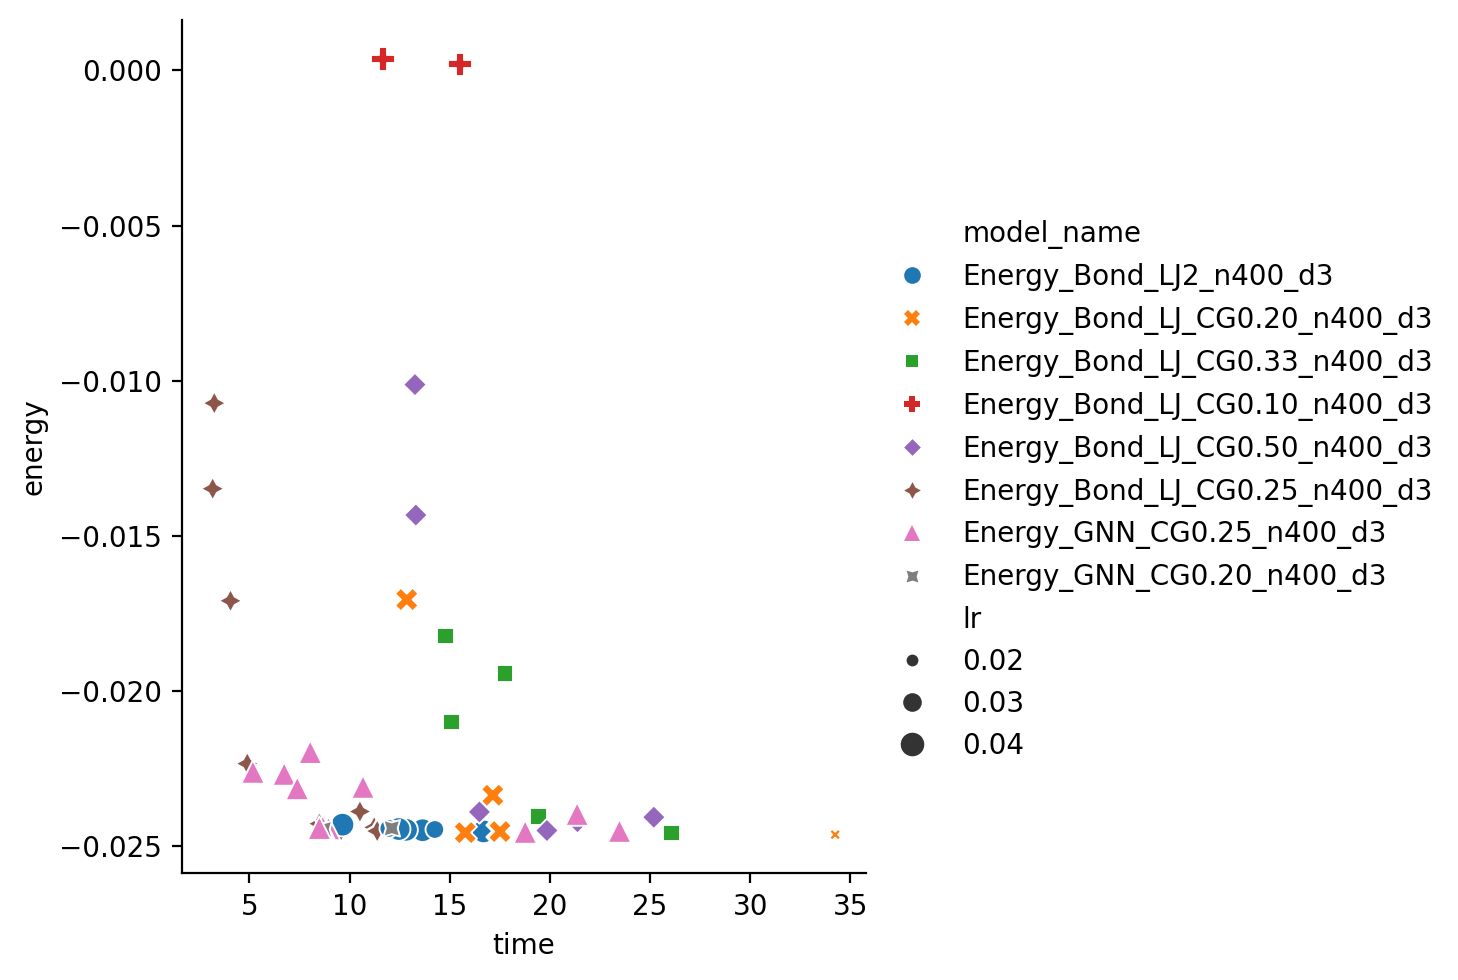

In [215]:
# we also want to plot experiments for a single energy_function
# we can use the pandas groupby method to filter the dataframe
# we can then use the plot_results method to plot the filtered dataframe

# 1. filter the dataframe
# 2. plot the filtered dataframe

# filter the dataframe
df = exp_logger.df
df = df[df['energy_function'] == 'Energy_Bond_LJ']

# plot the filtered dataframe using sns directly on df
sns.relplot(data = df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr')


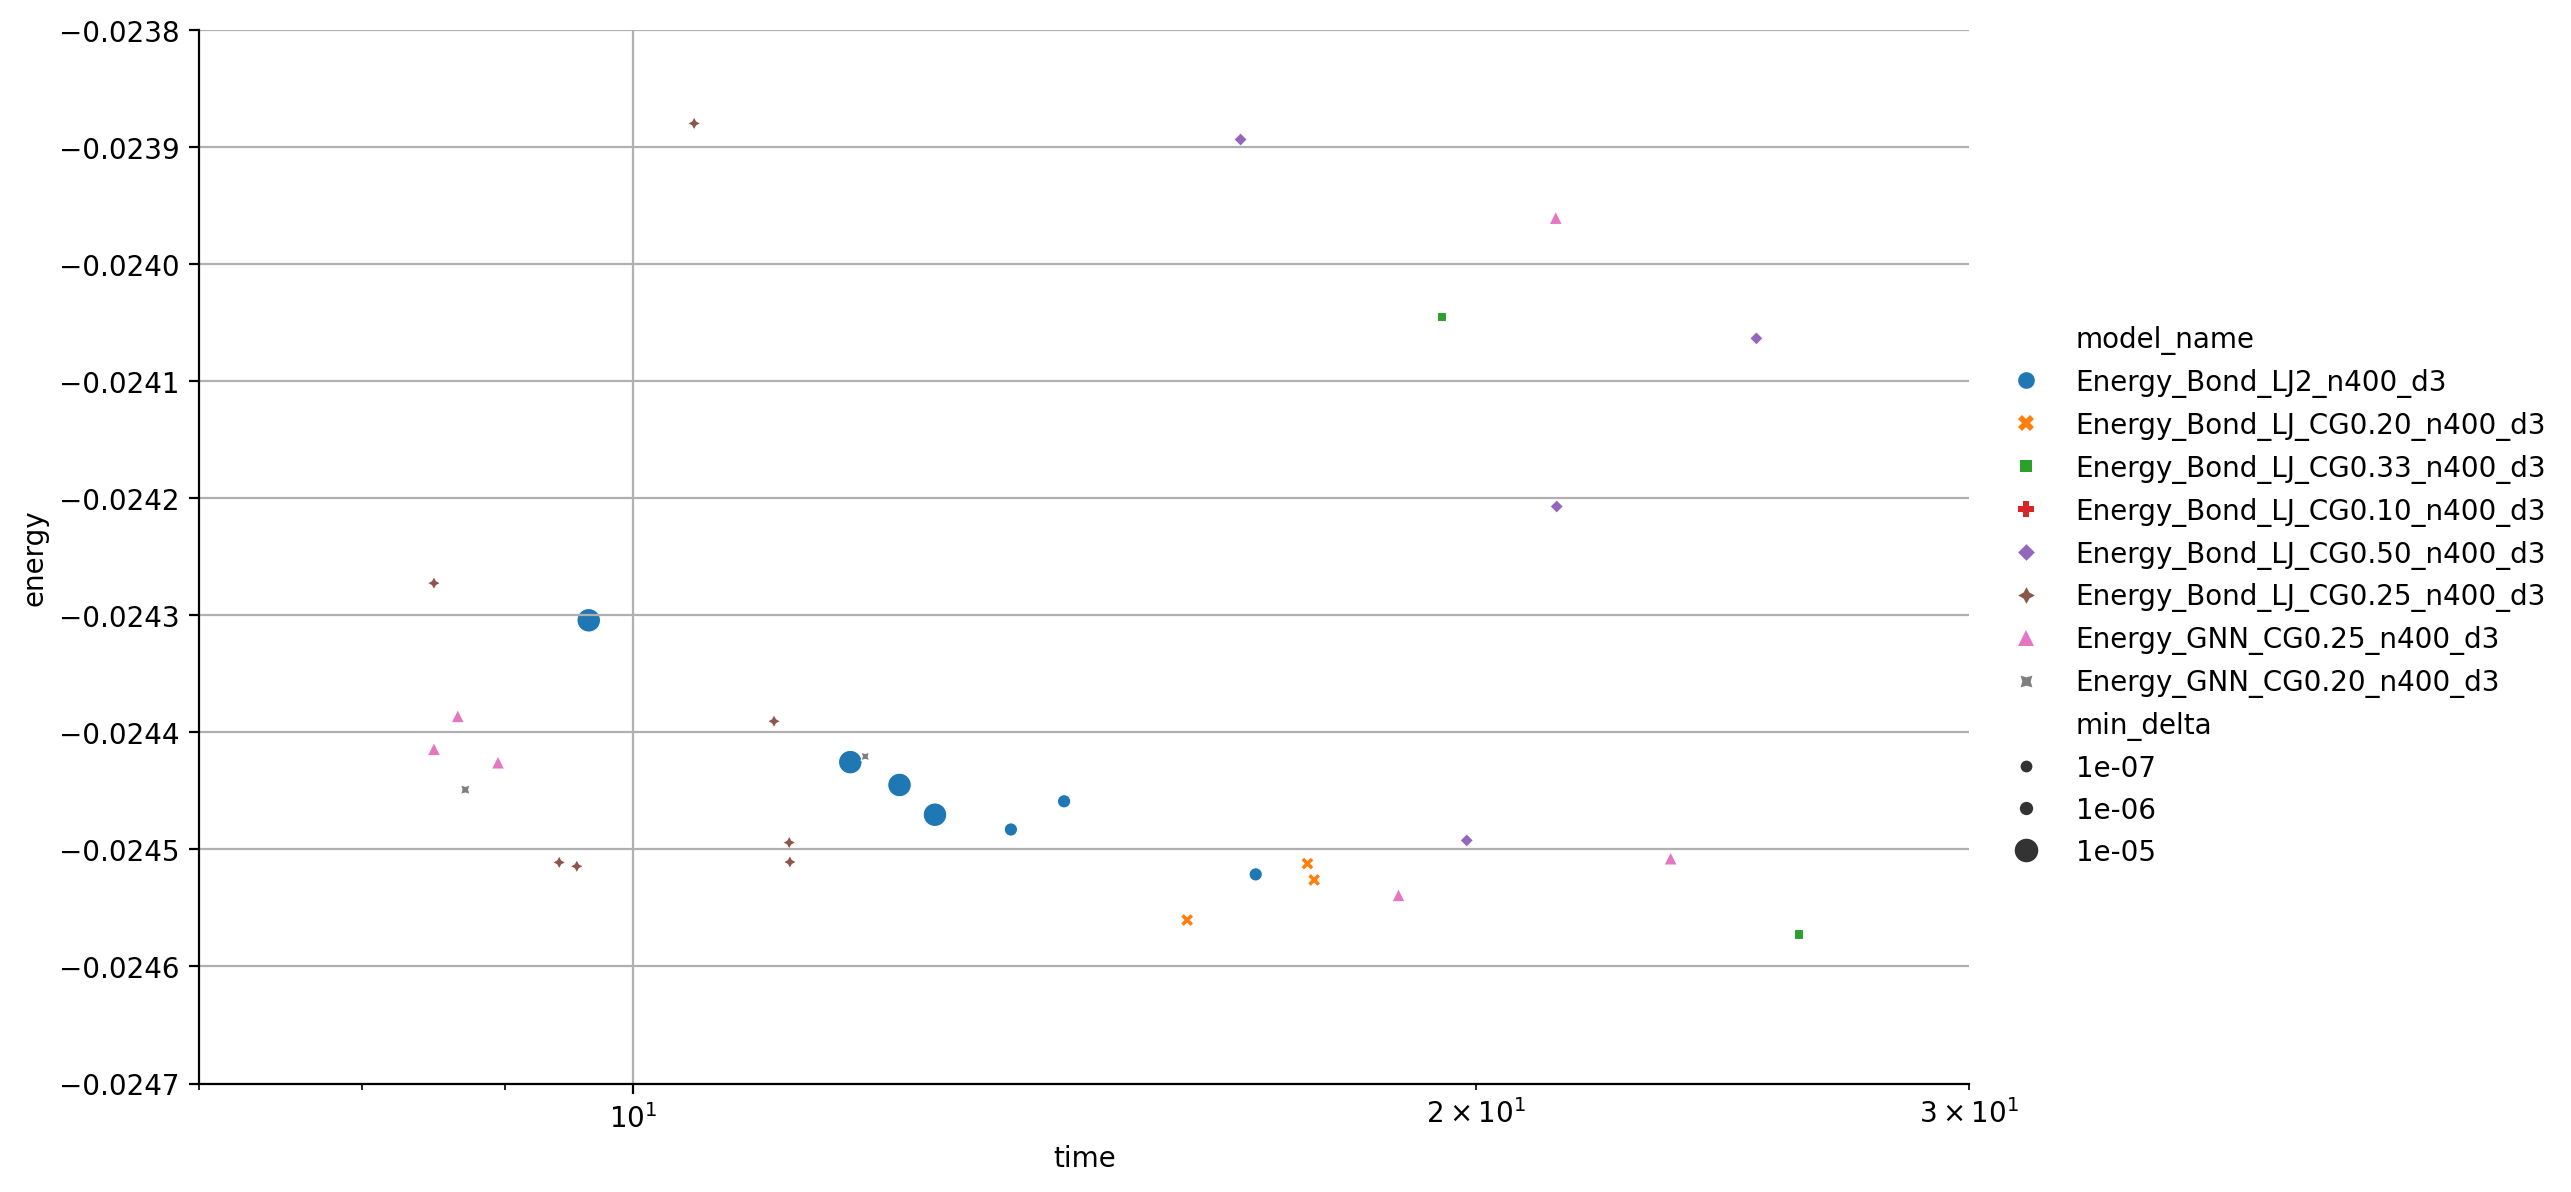

In [227]:
# plot the filtered dataframe using sns directly on df
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

plt.ylim(-.0247, -.0238)
plt.xlim(7,30)
plt.xscale('log')
plt.grid()

In [222]:
# print shape and name of parameters
for name, param in gnn_reparam.named_parameters():
    print(name, param.shape)
    
# print total number of parameters
sum(p.numel() for p in gnn_reparam.parameters())

latent_embedding torch.Size([400, 10])
gnn.layers.0.weight torch.Size([10, 5])
gnn.layers.0.bias torch.Size([5])
gnn.layers.0.self_loops torch.Size([10, 5])
gnn.layers.1.weight torch.Size([3, 5])
gnn.layers.1.bias torch.Size([3])


4123

In [51]:
energy_bond_lj.get_indices()

In [52]:
# cg_minimizer.early_stopping_triggered = False
h = gnn_minimizer.train(20000)

Early stopping at step 6760


In [53]:
len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}"

(339, '-0.0241, 8.22')

Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=8.31 s)')

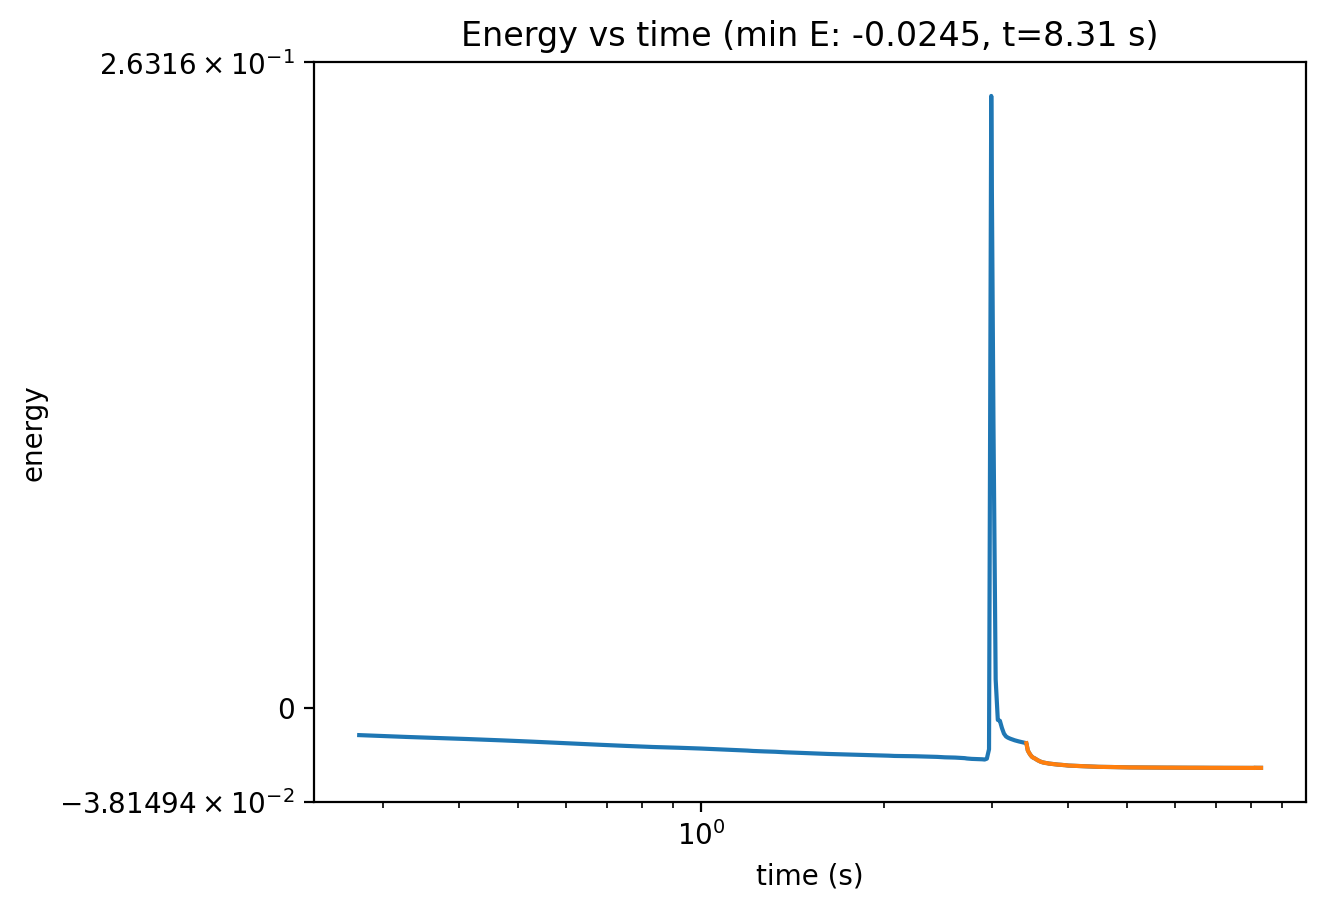

In [200]:
gnn_minimizer.plot_history(start=10)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [57]:
from coarsegrainer.plotting import plot_graph_3D,plot_line_3D

In [213]:
r = 1e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
# v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
v = plot_line_3D(V(gnn_minimizer.gnn()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [59]:
gnn_minimizer.start_fine_graining()

In [60]:
gnn_minimizer.min_delta

1e-06

In [61]:
# cg_minimizer.min_delta = 1e-6
gnn_minimizer.min_delta, gnn_minimizer.patience, gnn_minimizer.fine_grained, gnn_minimizer.early_stopping_triggered

(1e-06, 20, True, False)

In [62]:
gnn_minimizer.optimizer.param_groups[0]['params'][0].shape

torch.Size([400, 3])

In [63]:
# cg_minimizer.min_delta = 1e-6
# cg_minimizer.early_stopping_triggered = False
h = gnn_minimizer.train(20000)

Early stopping at step 9740


In [64]:
len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}"

(827, '-0.0245, 17.49')

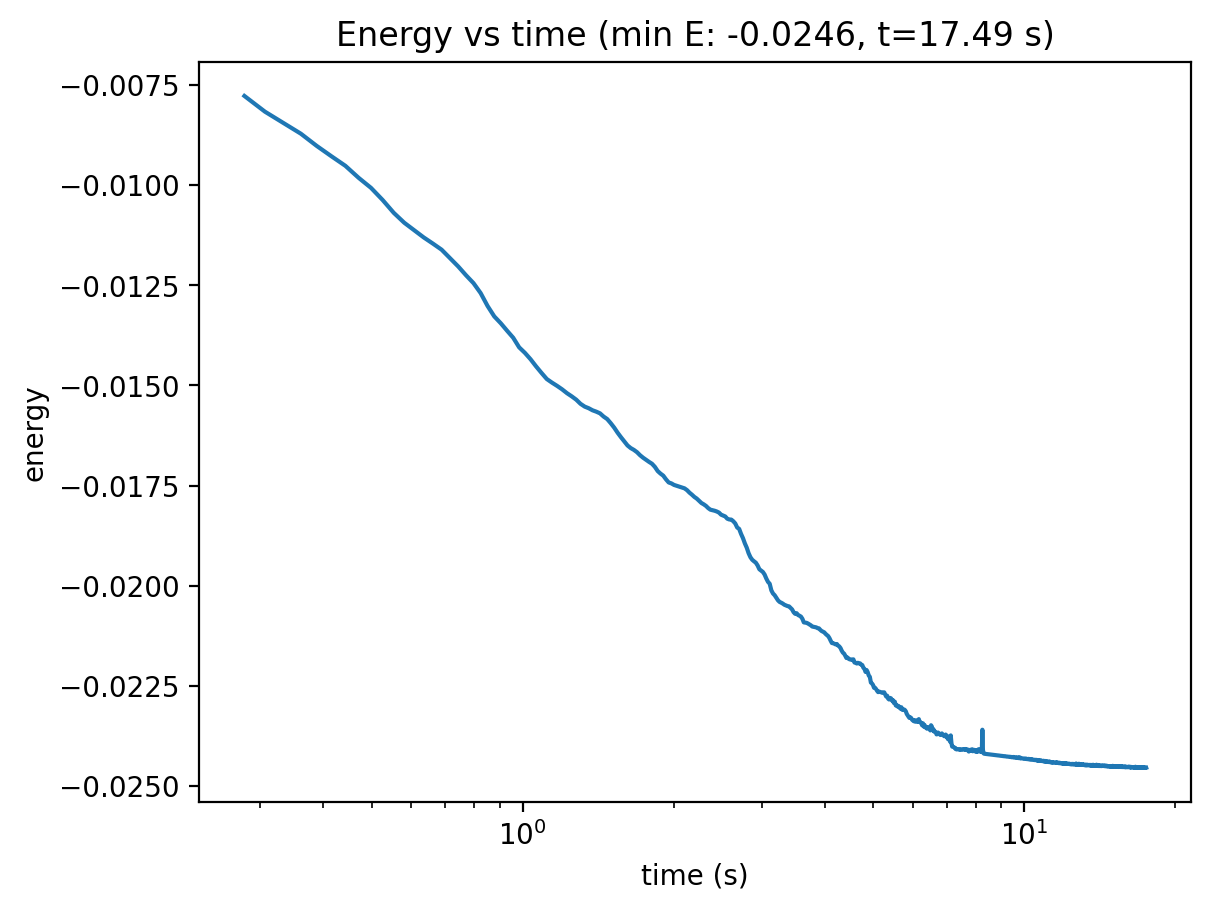

In [65]:
gnn_minimizer.plot_history(start=10)
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
plt.yscale('linear')


In [66]:
total_time = np.sum(h['time']) + cg_time
total_time

17.676391124725342

In [214]:
r = 5e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol